In [2]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
def preprocess(file_path):
    wav = load_wav(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [24]:
interpreter = tf.lite.Interpreter(model_path="../Training/Models/processor.tflite")

input_details = interpreter.get_input_details()    
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

input_shape = input_details[0]['shape']

b'..\\Logs\\Audio\\log.wav'


<function matplotlib.pyplot.show(close=None, block=None)>

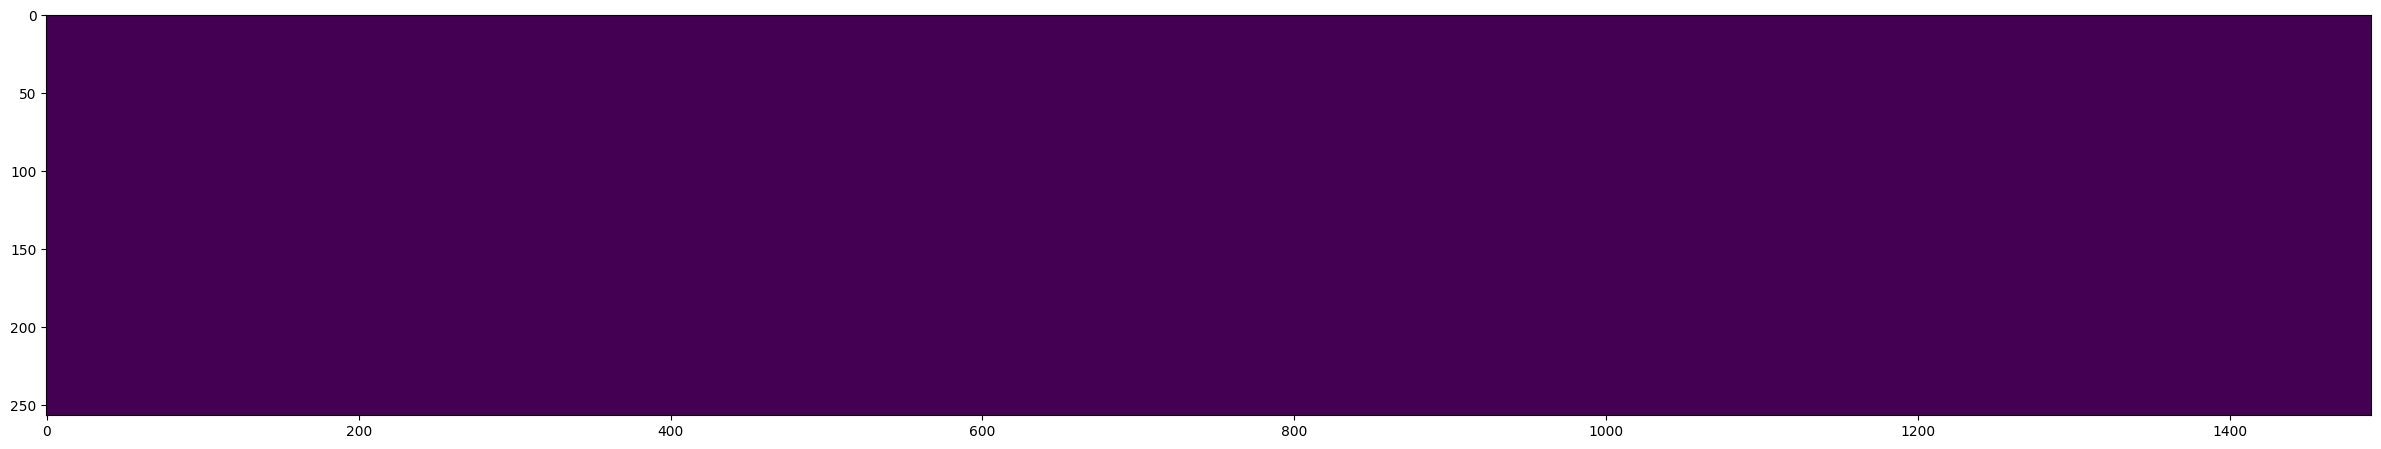

In [33]:
EVAL = "../Logs/Audio"

eval = tf.data.Dataset.list_files(EVAL +'/*.wav')

data = tf.data.Dataset.zip((eval, tf.data.Dataset.from_tensor_slices(tf.ones(len(eval)))))

filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram = preprocess(filepath)
print(filepath)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show

In [37]:
input_data = np.asarray(spectrogram, dtype=np.float32)

input_data = np.expand_dims(input_data, axis=0)

input_data.shape


(1, 1491, 257, 1)

In [43]:

#Predict model with processed data  
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])  
prediction

array([[0.9999938]], dtype=float32)

In [6]:
df = pd.read_csv('../Training/Data/WakeWord/WakeLog.csv')
list = df.iloc[0]['Data']
list

'[   0    0    0 ... 1518 1472 1355]'